In [23]:
import pickle;
import numpy as np;
from numpy.linalg import pinv;
from numpy.polynomial.legendre import legvander;
import tensorflow as tf

import control

In [24]:
import matplotlib
import matplotlib.pyplot as plt;
matplotlib.rcParams.update({'font.size':20}) # default font size on (legible) figures
colors =[[ 0.68627453,  0.12156863,  0.16470589],
       [ 0.96862745,  0.84705883,  0.40000001],
       [ 0.83137256,  0.53333336,  0.6156863 ],
       [ 0.03529412,  0.01960784,  0.14509805],
       [ 0.90980393,  0.59607846,  0.78039217],
       [ 0.69803923,  0.87843138,  0.72941178],
       [ 0.20784314,  0.81568629,  0.89411765]];

colors = np.asarray(colors); # defines a color palette 


In [54]:
def load_pickle_data(file_path,has_control,has_output):
        '''load pickle data file for deep Koopman dynamic mode decomposition. 
        Args: 
           file_path: 

        '''     
        file_obj = open(file_path,'rb');
        output_vec = pickle.load(file_obj);
        print(type(output_vec))
        Xp = None;
        Xf = None;
        Yp = None;
        Yf = None;
        Up = None;
        
        if type(output_vec) == list:
          Xp = output_vec[0]; # list of baseline observables, len(Yp) = (n_samps-1) 
          Xf = output_vec[1]; # list of baseline observables, len(Yf) = (n_samps-1)
          if has_control:
            Up = output_vec[2];
          if has_output:
            Yp = output_vec[3];
            Yf = output_vec[4]; 
            #print(Up[0:10]
          if len(Xp)<2:
            print("Warning: the time-series data provided has no more than 2 points.")
            
        if type(output_vec) == dict:
          Xp = output_vec['Xp'];
          Xf = output_vec['Xf'];
          Yp = output_vec['Yp'];
          Yf = output_vec['Yf'];
          if has_control:
            Up = output_vec['Up'];
          if has_output:
            Yp = output_vec['Yp'];
            Yf = output_vec['Yf']; 
          if len(Xp)<2:
            print("Warning: the time-series data provided has no more than 2 points.")
    
          
        #print("DEBUG:") + repr(len(output_vec));
          

        X_whole = [None]*(len(Xp)+1);
        
        for i in range(0,len(Xp)+1):
            if i == len(Xp):
                X_whole[i] = Xf[i-1];
            else:
                X_whole[i] = Xp[i];

        X_whole = np.asarray(X_whole);
        
        return np.asarray(Xp),np.asarray(Xf),X_whole,Up,Yp,Yf

In [26]:
with_control = 1;

sess = tf.InteractiveSession();

saver = tf.train.import_meta_graph('incoherent_ff_loop.pickle.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'));

psiyp = tf.get_collection('psiyp')[0];
psiyf = tf.get_collection('psiyf')[0];

if with_control:
    forward_prediction_control = tf.get_collection('forward_prediction_control')[0];
else:
    forward_prediction = tf.get_collection('forward_prediction')[0];
    
yp_feed = tf.get_collection('yp_feed')[0];
yf_feed = tf.get_collection('yf_feed')[0];
Kx = tf.get_collection('Kx')[0];
Kx_num = sess.run(Kx);
A = np.transpose(Kx_num); # Kx_num and Ku_num were defined using row multi. 

if with_control:
    psiu = tf.get_collection('psiu')[0];
    u_control = tf.get_collection('u_control')[0];
    Ku = tf.get_collection('Ku')[0];
    Ku_num = sess.run(Ku);
    B = np.transpose(Ku_num);




In [27]:
d


array([[-0.02369508+0.04208969j, -0.02369508-0.04208969j,
        -0.01731523-0.04855373j, -0.01731523+0.04855373j,
         0.07543935+0.j        , -0.07006212-0.00856016j,
        -0.07006212+0.00856016j,  0.06410325-0.01882213j,
         0.06410325+0.01882213j,  0.06769864+0.14934605j,
         0.06769864-0.14934605j, -0.00109428+0.02926941j,
        -0.00109428-0.02926941j,  0.05520908+0.05615653j,
         0.05520908-0.05615653j,  0.10942114+0.j        ,
        -0.126038  +0.03179937j, -0.126038  -0.03179937j,
         0.07233723+0.j        , -0.11649933+0.j        ,
        -0.11409412+0.02300694j, -0.11409412-0.02300694j,
         0.07450458+0.j        , -0.15859245+0.j        ,
         0.08057181+0.j        ],
       [-0.00600847+0.02487306j, -0.00600847-0.02487306j,
        -0.03736554-0.12285201j, -0.03736554+0.12285201j,
         0.06304701+0.j        , -0.03538285+0.00228292j,
        -0.03538285-0.00228292j,  0.02851049+0.02109626j,
         0.02851049-0.02109626j,  0.09

1.0432005
[-0.11649933  0.1327844   0.35650772  0.08869991 -0.05575847  0.07639021
 -0.03315378  0.28297216  0.41866893 -0.06260612 -0.10091988  0.04433807
  0.33187103 -0.32089862 -0.10035186  0.12338199  0.0655601   0.13235953
  0.43312803  0.13582622  0.13838682 -0.1743142   0.07384725 -0.05921975
  0.16610101]


array([[ 2.31209004e+02, -2.57633213e+02, -6.60659634e+02,
        -9.06210211e+01,  1.26762461e+02, -1.14830772e+02,
         8.02658929e+01, -4.76849866e+02, -6.52353445e+02,
         1.39153799e+02,  1.66659719e+02, -1.09433411e+02,
        -5.21067321e+02,  5.32539401e+02,  1.87925531e+02,
        -3.16570596e+02, -3.00405975e+01, -2.32335876e+02,
        -7.54734255e+02, -1.79835015e+02, -2.79607420e+02,
         3.43121176e+02, -1.90976595e+02,  1.43786611e+02,
        -2.64779520e+02],
       [-2.57633213e+02,  2.90478854e+02,  7.42275776e+02,
         1.00056716e+02, -1.43860692e+02,  1.29559022e+02,
        -9.07515022e+01,  5.38117686e+02,  7.26694589e+02,
        -1.55759995e+02, -1.87372288e+02,  1.21376520e+02,
         5.81234019e+02, -5.96308417e+02, -2.12004368e+02,
         3.62265545e+02,  3.30281347e+01,  2.59961369e+02,
         8.50568241e+02,  2.00002150e+02,  3.14739569e+02,
        -3.85158186e+02,  2.17699101e+02, -1.65797368e+02,
         2.98094515e+02],
    

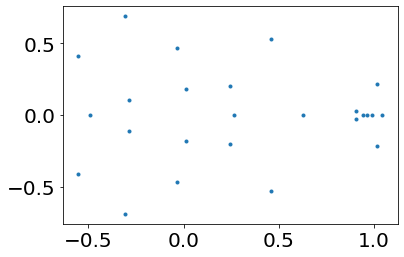

In [36]:
[d,v] = np.linalg.eig(Kx_num)
print(np.max(np.abs(d)))
print(np.real(v[:,np.argmax(np.abs(d))]))

plt.plot(np.real(d),np.imag(d),'.')

import control

sys = control.ss(Kx_num,B,np.eye(Kx_num.shape[0]),np.zeros( ( A.shape[0],B.shape[1]) ))
control.dlyap(Kx_num,np.dot(B,B.T))


In [70]:
data_directory = 'koopman_data/'
data_suffix = 'incoherent_ff_loop.pickle';
data_file = data_directory + data_suffix;
Yp,Yf,Ywhole,u_control_all_training,fake_outputp,fake_outputf = load_pickle_data(data_file,1,0);
with_control = 1;
Y_p_old = Yp

num_trains = len(Yp)*5.0/10;
train_indices = range(0,np.int(num_trains),1);#np.random.randint(0,len(Yp),num_trains)
test_indices = range(np.int(num_trains),len(Yp),1);#np.random.randint(0,len(Yp),len(Yp)-num_trains);

num_bas_obs = len(Yp[0]);
print("[INFO]: Number of training datapoints " + repr(num_trains));
print("[INFO]: Number of state components: " + repr(len(Yp[0])));


if with_control:
    U_test = u_control_all_training[test_indices,:];
    U_train = u_control_all_training[train_indices,:];
    n_inputs_control = u_control_all_training.shape[1]

<class 'list'>
[INFO]: Number of training datapoints 4950.0
[INFO]: Number of state components: 5


In [76]:
u_control_all_training.shape
n_points_pred

4949

###  N-Step Prediction Visualization ###

[RESULT] n-step prediction error: 0.492263


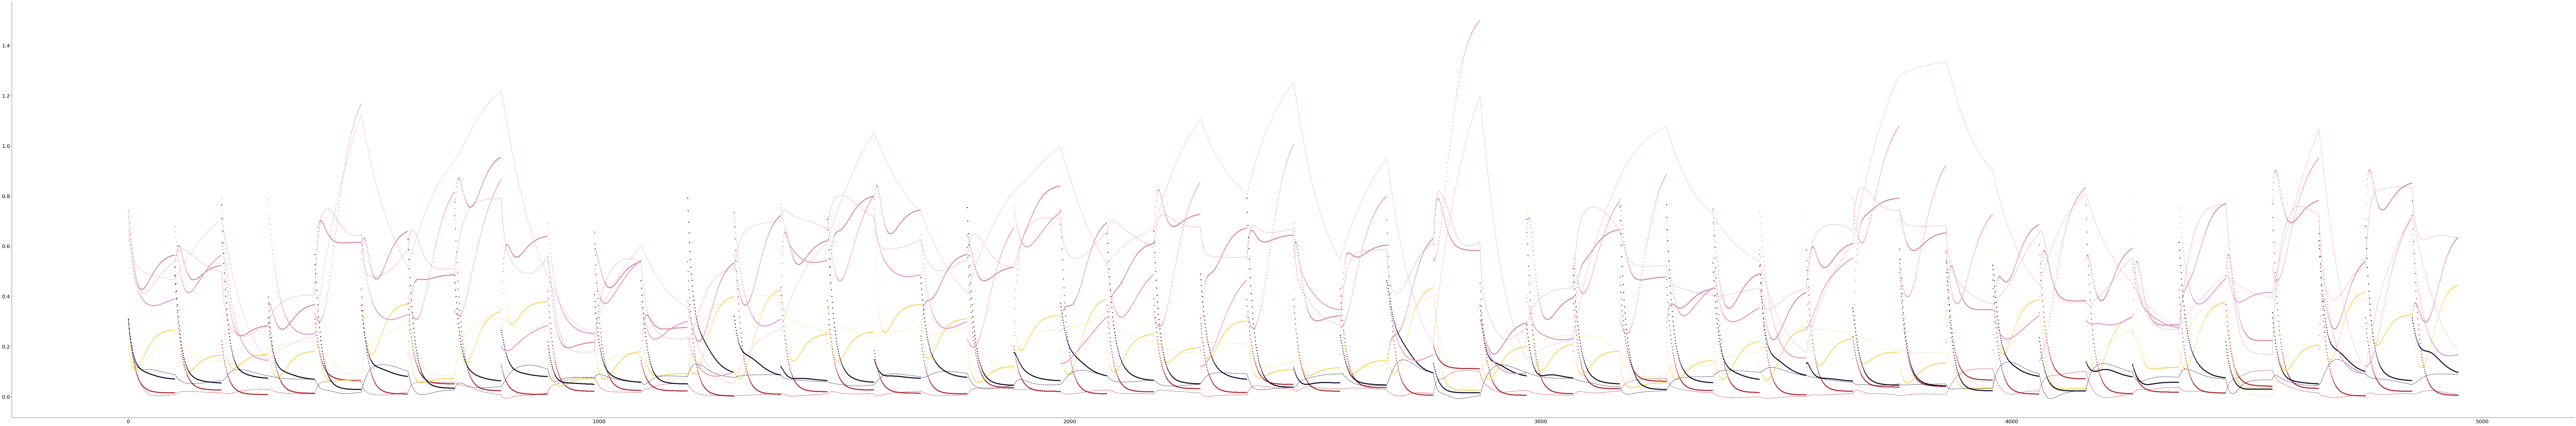

In [83]:
# # # - - - n-step Prediction Error Analysis - - - # # # 

  
n_points_pred = int(len(Y_p_old) - test_indices[0]-1);

init_index = int(test_indices[0]);
Yf_final_test_stack_nn = np.asarray(Y_p_old).T[:,init_index:(init_index+1)+n_points_pred]
Ycurr = np.asarray(Y_p_old).T[:,init_index]
Ycurr = np.transpose(Ycurr);
if with_control:
  Uf_final_test_stack_nn = np.asarray(u_control_all_training).T[:,init_index:(init_index+1)+n_points_pred]

#Reshape for tensorflow, which operates using row multiplication. 
Ycurr = Ycurr.reshape(1,num_bas_obs);
psiyp_Ycurr = psiyp.eval(feed_dict={yp_feed:Ycurr});
psiyf_Ycurr = psiyf.eval(feed_dict={yf_feed:Ycurr});


## Define a growing list of vector valued observables that is the forward prediction of the Yf snapshot matrix, initiated from an initial condition in Yp_final_test.   
Yf_final_test_ep_nn = [];  #Variable to store final Test Predictions of Yforwrad snapshots, using an extended or multi-step prediction approach on the deepDMD basis.  
Yf_final_test_ep_nn.append(psiyp_Ycurr.tolist()[0][0:num_bas_obs]); # append the initial seed state value.

for i in range(0,n_points_pred):
  if with_control:
    if len(U_test[i,:])==1:
      U_temp_mat = np.reshape(Uf_final_test_stack_nn[i,:],(1,1));
      psiyp_Ycurr = sess.run(forward_prediction_control, feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs],u_control:U_temp_mat});#
    else:
      U_temp_mat = np.reshape(Uf_final_test_stack_nn.T[i,:],(1,n_inputs_control));
      psiyp_Ycurr = sess.run(forward_prediction_control, feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs],u_control:U_temp_mat});# 
  else:
    psiyp_Ycurr = sess.run(forward_prediction,feed_dict={yp_feed:psiyp_Ycurr[:,0:num_bas_obs]});

  Yout = psiyp_Ycurr.tolist()[0][0:num_bas_obs];
  Yf_final_test_ep_nn.append(Yout);


Yf_final_test_ep_nn = np.asarray(Yf_final_test_ep_nn);
Yf_final_test_ep_nn = np.transpose(Yf_final_test_ep_nn);

prediction_error = np.linalg.norm(Yf_final_test_stack_nn-Yf_final_test_ep_nn,ord='fro')/np.linalg.norm(Yf_final_test_stack_nn,ord='fro');
print('%s%f' % ('[RESULT] n-step prediction error: ',prediction_error));

import matplotlib
matplotlib.rcParams.update({'font.size':20})

plt.figure(figsize=(180,30))
### Make a Prediction Plot
x_range = np.arange(0,n_points_pred,1)
#x_range = np.arange(0,Yf_final_test_stack_nn.shape[1],1);
for i in range(0,num_bas_obs):
    plt.plot(x_range,Yf_final_test_ep_nn[i,0:len(x_range)],'--',color=colors[i,:]);
    plt.plot(x_range,Yf_final_test_stack_nn[i,0:len(x_range)],'.',color=colors[i,:]);
axes = plt.gca();
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

#plt.legend(loc='best');
#plt.xlabel('t');
#plt.ylim([0,3.0])
fig = plt.gcf();

target_file = data_suffix.replace('.pickle','')+'final_nstep_prediction.pdf';
plt.savefig(target_file);
plt.show();


